Enhanced Musical Instrument Detector
-----------------------------------
This program detects musical instruments in audio files and estimates their proportions.

Enter path to an audio file: /content/khud-ko-tujh-mein-paaun-267037.mp3
Loading instrument detection model...
14096/14096 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model loaded successfully!

Analyzing audio file: /content/khud-ko-tujh-mein-paaun-267037.mp3
Loading audio file: /content/khud-ko-tujh-mein-paaun-267037.mp3
Audio duration: 159.26 seconds
Analyzing 54 segments...

Detected Instruments:
- Guitar: 92.86%
- Plucked String: 7.14%


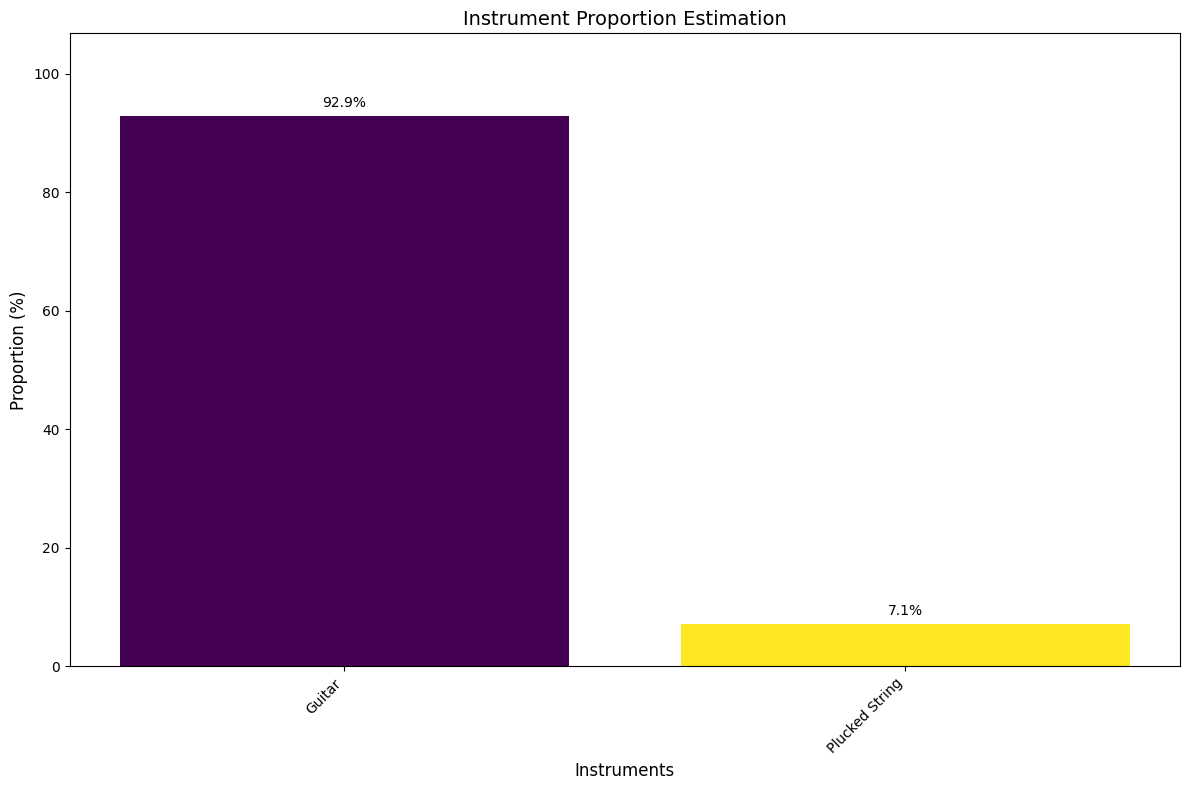

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import librosa
import matplotlib.pyplot as plt
import warnings
import os
import tempfile
from sklearn.preprocessing import MinMaxScaler
import soundfile as sf
from tqdm import tqdm

# Suppress warnings
warnings.filterwarnings('ignore')

class EnhancedInstrumentDetector:
    def __init__(self):
        """Initialize the instrument detector with YAMNet model"""
        print("Loading instrument detection model...")
        # Load YAMNet model
        self.yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')

        # Load YAMNet class mapping
        self.yamnet_class_map_path = tf.keras.utils.get_file('yamnet_class_map.csv',
                                                          'https://raw.githubusercontent.com/tensorflow/models/master/research/audioset/yamnet/yamnet_class_map.csv')
        self.yamnet_class_map = pd.read_csv(self.yamnet_class_map_path)
        self.yamnet_class_names = self.yamnet_class_map['display_name'].tolist()

        # Define musical instrument classes we're interested in
        self.instrument_categories = {
            'Percussion': ['Drum', 'Drum kit', 'Snare drum', 'Bass drum', 'Cymbal', 'Hi-hat', 'Tambourine', 'Drumstick', 'Maracas', 'Tabla'],
            'Guitar': ['Guitar', 'Electric guitar', 'Acoustic guitar', 'Guitar string', 'Guitar pick'],
            'Bass': ['Bass guitar', 'Double bass', 'Electric bass guitar'],
            'Piano': ['Piano', 'Grand piano', 'Electric piano', 'Keyboard (musical)'],
            'Strings': ['Violin, fiddle', 'Cello', 'Viola', 'String section', 'Pizzicato'],
            'Brass': ['Trumpet', 'Trombone', 'Brass instrument', 'French horn', 'Tuba'],
            'Woodwinds': ['Saxophone', 'Flute', 'Clarinet', 'Oboe', 'Bassoon', 'Reed (music)'],
            'Vocals': ['Singing', 'Vocal music', 'Voice', 'Choir', 'A cappella', 'Falsetto', 'Harmony'],
            'Synthesizer': ['Synthesizer', 'Electronic music', 'Techno', 'Synthesizer pad'],
            'Organ': ['Organ', 'Hammond organ', 'Church organ'],
            'Plucked String': ['Banjo', 'Mandolin', 'Ukulele', 'Harp', 'Zither', 'Sitar'],
            'Other': ['Accordion', 'Harmonica', 'Bagpipes', 'Didgeridoo', 'Xylophone', 'Vibraphone', 'Steelpan', 'Glockenspiel']
        }

        # Create a mapping from YAMNet class names to our instrument categories
        self.yamnet_to_instrument_category = {}
        for category, instruments in self.instrument_categories.items():
            for instrument in instruments:
                # Find the index in yamnet_class_names that matches this instrument
                for i, name in enumerate(self.yamnet_class_names):
                    if instrument.lower() == name.lower():
                        self.yamnet_to_instrument_category[i] = category
                        break

        # Set detection thresholds
        self.frame_threshold = 0.15  # Threshold for single frame detection
        self.segment_threshold = 0.05  # Threshold for segment-level detection

        print("Model loaded successfully!")

    def detect_instruments(self, audio_file, segment_duration=3.0, verbose=True):
        """
        Detect musical instruments in an audio file with temporal analysis

        Args:
            audio_file: Path to audio file or audio data bytes
            segment_duration: Duration of each segment in seconds for temporal analysis
            verbose: Whether to print progress information

        Returns:
            Dictionary with detected instruments and their proportions
        """
        # Handle both file paths and bytes data
        if isinstance(audio_file, bytes):
            with tempfile.NamedTemporaryFile(suffix='.wav', delete=False) as tmp:
                tmp.write(audio_file)
                tmp_path = tmp.name
            audio_path = tmp_path
        else:
            audio_path = audio_file

        if verbose:
            print(f"Loading audio file: {audio_path}")

        # Load audio with librosa
        try:
            y, sr = librosa.load(audio_path, sr=16000, mono=True)
        except Exception as e:
            print(f"Error loading audio file: {e}")
            return {}

        duration = len(y) / sr
        if verbose:
            print(f"Audio duration: {duration:.2f} seconds")

        # Process entire audio with YAMNet to get frame-level predictions
        scores, embeddings, log_mel_spectrogram = self.yamnet_model(y)
        scores_np = scores.numpy()

        # Analyze audio in segments for temporal instrument detection
        segment_samples = int(segment_duration * sr)
        num_segments = max(1, int(np.ceil(len(y) / segment_samples)))

        # Initialize counters for each instrument category
        category_counts = {category: 0 for category in self.instrument_categories.keys()}
        frame_counts = {category: 0 for category in self.instrument_categories.keys()}
        total_frames = scores_np.shape[0]

        if verbose:
            print(f"Analyzing {num_segments} segments...")

        # Process each audio segment
        for i in range(num_segments):
            start_sample = i * segment_samples
            end_sample = min(len(y), (i + 1) * segment_samples)
            segment = y[start_sample:end_sample]

            # Get segment start and end frames in the YAMNet output
            # YAMNet produces scores at a rate of ~31.25 Hz (frame length of 32ms)
            segment_duration_sec = len(segment) / sr
            frames_per_second = scores_np.shape[0] / duration
            start_frame = int(i * segment_duration * frames_per_second)
            end_frame = min(int((i + 1) * segment_duration * frames_per_second), scores_np.shape[0])

            # Extract segment predictions
            segment_scores = scores_np[start_frame:end_frame]

            # Count frames where each instrument category is detected
            for frame_idx, frame_scores in enumerate(segment_scores):
                # Find the top instrument classes in this frame
                top_indices = np.where(frame_scores > self.frame_threshold)[0]

                # Map these to our instrument categories
                detected_categories = set()
                for idx in top_indices:
                    if idx in self.yamnet_to_instrument_category:
                        category = self.yamnet_to_instrument_category[idx]
                        detected_categories.add(category)

                # Increment counters
                for category in detected_categories:
                    frame_counts[category] += 1

        # Calculate proportions based on frame counts
        instrument_proportions = {}
        for category, count in frame_counts.items():
            if count > 0:
                # Calculate proportion as percentage of total frames
                proportion = (count / total_frames) * 100

                # Only include categories that appear in a significant portion of frames
                if proportion > self.segment_threshold:
                    instrument_proportions[category] = proportion

        # Normalize proportions to sum to 100%
        if instrument_proportions:
            total_proportion = sum(instrument_proportions.values())
            instrument_proportions = {inst: (prop / total_proportion) * 100
                                      for inst, prop in instrument_proportions.items()}

        # Cleanup temp file if created
        if isinstance(audio_file, bytes) and os.path.exists(tmp_path):
            os.unlink(tmp_path)

        return instrument_proportions

    def visualize_results(self, instrument_proportions):
        """
        Create visualization of instrument proportions

        Args:
            instrument_proportions: Dictionary with instrument proportions

        Returns:
            Matplotlib figure
        """
        if not instrument_proportions:
            fig, ax = plt.subplots(figsize=(10, 6))
            ax.text(0.5, 0.5, "No instruments detected", ha='center', va='center', fontsize=14)
            ax.set_xticks([])
            ax.set_yticks([])
            return fig

        # Create bar chart
        fig, ax = plt.subplots(figsize=(12, 8))
        instruments = list(instrument_proportions.keys())
        proportions = list(instrument_proportions.values())

        # Sort by proportion (descending)
        sorted_indices = np.argsort(proportions)[::-1]
        instruments = [instruments[i] for i in sorted_indices]
        proportions = [proportions[i] for i in sorted_indices]

        # Set up bars with colors
        cmap = plt.cm.get_cmap('viridis', len(instruments))
        colors = [cmap(i) for i in range(len(instruments))]

        bars = ax.bar(instruments, proportions, color=colors)

        # Add labels and values on top of bars
        for bar, proportion in zip(bars, proportions):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                    f"{proportion:.1f}%",
                    ha='center', va='bottom', rotation=0, fontsize=10)

        ax.set_xlabel('Instruments', fontsize=12)
        ax.set_ylabel('Proportion (%)', fontsize=12)
        ax.set_title('Instrument Proportion Estimation', fontsize=14)
        plt.xticks(rotation=45, ha='right')
        plt.ylim(0, max(proportions) * 1.15)  # Make room for labels
        plt.tight_layout()

        return fig

def analyze_audio_file(file_path):
    """
    Analyze an audio file and detect instruments

    Args:
        file_path: Path to the audio file

    Returns:
        None (prints results and shows visualization)
    """
    # Initialize detector
    detector = EnhancedInstrumentDetector()

    # Detect instruments
    print(f"\nAnalyzing audio file: {file_path}")
    instrument_proportions = detector.detect_instruments(file_path)

    # Display results
    if instrument_proportions:
        print("\nDetected Instruments:")
        for inst, prop in sorted(instrument_proportions.items(), key=lambda x: x[1], reverse=True):
            print(f"- {inst}: {prop:.2f}%")

        # Visualize results
        fig = detector.visualize_results(instrument_proportions)
        plt.show()
    else:
        print("No instruments detected in the audio file.")

def main():
    """Main function to run the instrument detector"""
    print("Enhanced Musical Instrument Detector")
    print("-----------------------------------")
    print("This program detects musical instruments in audio files and estimates their proportions.")

    # Get audio file path from user
    audio_path = input("\nEnter path to an audio file: ")

    if os.path.exists(audio_path):
        analyze_audio_file(audio_path)
    else:
        print(f"Error: File not found at {audio_path}")

if __name__ == "__main__":
    # Initialize pandas for CSV reading
    import pandas as pd
    main()

